In [11]:
# -*- coding: utf-8 -*-
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import cv2
from scipy.cluster.vq import vq, kmeans
from matplotlib import pyplot as plt
import numpy as np
import time as t
import os
import math
import pandas as pd

import cv2
import dlib
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import math
from collections import Counter
import copy

In [12]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(30,30), ratio=1, conv_color = False):
    
    if conv_color:
        list_of_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in list_of_images]
    
    num_img = len(list_of_images)
    row = math.ceil( num_img / no_of_columns )
    
    if figsize[1] == 0:
        fig = plt.figure(figsize=(figsize[0], figsize[0]*row/no_of_columns/ratio))
    else:
        fig = plt.figure(figsize=figsize)
        
    for i, img in enumerate(list_of_images):
        if list_of_titles:
            fig.add_subplot( row, no_of_columns , i+1, title = list_of_titles[i])
        else:
            fig.add_subplot( row, no_of_columns , i+1)
        plt.imshow(list_of_images[i])
        plt.axis('off')
    plt.show()
        

In [13]:
def get_lankmark(path):
    detector = dlib.get_frontal_face_detector()
    landmark_predictor = dlib.shape_predictor(
        r'./models/shape_predictor_68_face_landmarks.dat')
    img = cv2.imread(path)
    faces = detector(img, 1)
    landmark = []
    rect = []
    if (len(faces) > 0):
        for k, d in enumerate(faces):
            rect.append( [( d.left(), d.top() ), ( d.right(), d.bottom() )] )
            
            shape = landmark_predictor(img, d)
            feas = []  #lankmark points
            for i in range(68):
                num = str(shape.part(i))[1:-1].split(",")
                feas.append( (int(num[0]), int(num[1])) ) 
            landmark.append(feas)
    
    return img, rect, landmark

In [14]:
color_labels = ['black', 'blue', 'yellow', 'white', 'red']

organ_dirs = {#'jaw':'./jaw/', 
              'cheek_l':'./cheek_l/', 
              'cheek_r':'./cheek_r/', 
              'nose':'./nose/', 
              'lip':'./lip/', 
              'forehead':'./forehead/', 
              'neck':'./neck/'
             }

face_diagnose = {
'red':'面赤色：\n面色赤色为暑热之色，手少阴经之色，心包络，小肠之色。主热证，赤色重为实热，微赤为虚热。因气血得热则行，热盛而血脉充盈，血色上荣，所以面色赤红。\n红色对应心，面色红多与心有关。推荐几种养心的食物，如苦菜，大头菜，白果等都是很好的养心食物。',
'yellow': '面黄色：\n面部黄色为湿土之色、脾胃之色、足太阴经之色。为风为热，主虚证、湿证。黄色乃脾虚湿蕴之象征。脾失健运、水湿内停、气血不充，致使肌肤失于充养，所以面色发黄。\n黄色和脾对应，面色黄多与脾有关。脾为气血生化之源。脾胃功能运健，则气血旺盛，见面色红润，肌肤弹性良好。下面推荐几种养脾是食物，如茄子、蘑菇、胡萝卜、土豆、黄瓜、冬瓜、藕、梨、苹果、香蕉、西瓜。',
'white':'面白色：\n面部白色为燥金之色，手太阴经之色，肺与大肠之色。主寒证、虚证、脱血、夺气。白色为气血虚弱不能荣养机体的表现。阳气不足，气血运行无力，或耗气失血不充，血脉空虚，均可呈现白色。\n面白对应肺，面色白多与肺有关。肺的气机以宣降为顺，人体通过肺气的宣发和肃降，使气血津液得以布散全身。这里推荐几种养肺的食物，如胡椒、辣椒、葱、蒜、花椒等都是很好的养肺食物 ',
'black':'面黑色：\n面黑色主肾虚证、水饮证、寒证、痛证及淤血证。黑为阴寒水盛之色。由于肾阳虚衰，水饮不化，气化不行，阴寒内盛，血失温养，经脉拘急，气血不畅，古面色黧黑。\n黑色对应肾，面色黑多与肾有关。肾主藏精。肾精充盈，肾气旺盛时，五脏功能方可正常运行。推荐几种养肾食物，如海带、紫菜、海参等都是很好的养肾食物。',
'blue':'面青色：\n面青色主寒证、痛证、淤血证、惊风证、肝病。青色为筋脉阻滞，气血不通之象。寒主收引主凝滞，寒盛而留于血脉，则气滞血瘀，故面色发青。\n青色与肝对应，面色青多与肝有关。肝主藏血，主疏泄，能调节血流量和调畅全身气机，使气血平和，面部血液运行充足。养肝的食物有橘子、橄榄、柠檬、枇杷、芒果、石榴等。',
}

def get_organ_boxes(landmark):
    #define boxes coordinate
    return {
    #forehead
    'forehead':(
        landmark[0][19][0], #x_left_top
        landmark[0][19][1] - (landmark[0][23][0] - landmark[0][20][0]),  #y_left_top
        landmark[0][24][0], #x_right_bottom
        min(landmark[0][17][1], landmark[0][18][1], landmark[0][19][1], landmark[0][20][1]), #y_right_bottom
    ),
    #left cheek
    'cheek_l':(
        min(landmark[0][1][0], landmark[0][2][0], landmark[0][3][0]), #x_left_top
        max(landmark[0][36][1], landmark[0][39][1], landmark[0][40][1], landmark[0][41][1]), #y_left_top
        (landmark[0][31][0] + landmark[0][31][0] - landmark[0][32][0]), #x_right_bottom
        landmark[0][49][1], #y_right_bottom
    ),
    #right cheeka
    'cheek_r':(
        (landmark[0][35][0]+landmark[0][35][0]-landmark[0][34][0]), #x_left_top
        max(landmark[0][46][1], landmark[0][47][1], landmark[0][45][1], landmark[0][42][1]), #y_left_top
        landmark[0][15][0], #x_right_bottom
        landmark[0][63][1], #y_right_bottom
    ),
    #nose
    'nose':(
        (landmark[0][31][0] + landmark[0][31][0] - landmark[0][32][0]), #x_left_top
        landmark[0][27][1], #y_left_top
        (landmark[0][35][0]+landmark[0][35][0]-landmark[0][34][0]), #x_right_bottom
        max(landmark[0][31][1], landmark[0][32][1], landmark[0][33][1], landmark[0][34][1], landmark[0][35][1]), #y_right_bottom
    ),
    #lip
    'lip':(
        landmark[0][48][0], #x_left_top
        min(landmark[0][50][1], landmark[0][52][1]),  #y_left_top
        landmark[0][54][0], #x_right_bottom
        max(landmark[0][56][1], landmark[0][57][1], landmark[0][58][1]), #y_right_bottom
    ),
    #jaw
    'jaw': (
        landmark[0][5][0], #x_left_top
        landmark[0][57][1], #y_left_top
        landmark[0][11][0], #x_right_bottom
        landmark[0][8][1] #y_right_bottom
    ),
    'neck':(
        landmark[0][5][0], #x_left_top
        landmark[0][8][1], #y_left_top
        landmark[0][11][0], #x_right_bottom
        landmark[0][8][1] + landmark[0][8][1] - landmark[0][57][1], #y_right_bottom
    ),
    }


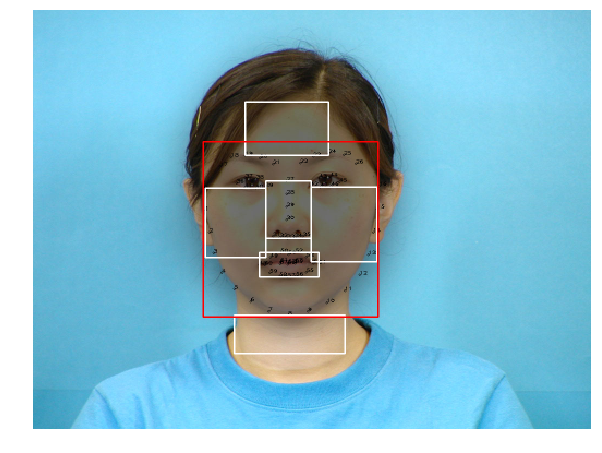

In [16]:
sample_dir = './test_imgs/'
imgs = []
face_imgs = os.listdir(sample_dir)


img_face = []
img_organs = {}
img_origs = []
# for face_img in face_imgs[idx:idx+10]:
for face_img in face_imgs:
    #extract landmark features
    img, rect, landmark = get_lankmark('./test/change_face_color.jpg')
#     img, rect, landmark = get_lankmark('./test/f1-001-01_yellow.jpg')
#     img, rect, landmark = get_lankmark(sample_dir + face_img)
    img_face.append(img)
    img_origs.append(copy.copy(img))
    organ_boxes = get_organ_boxes(landmark)
    
    
    # cut different parts of face
    for organ in organ_dirs:
#         print (organ)

        organ_crop = img[ organ_boxes[organ][1]:organ_boxes[organ][3],
                                                 organ_boxes[organ][0]:organ_boxes[organ][2] ]
        
#         cv2.imwrite(organ_dirs[organ] + face_img, organ_crop)
        img_organs[organ] = cv2.resize(organ_crop, (120,120))
    # draw face rect and landmark features

    for i, feat_point in enumerate(landmark[0]):
        cv2.circle(img, feat_point, 2, (0, 0, 0))
        cv2.putText(img, str(i), feat_point, 1, 0.7, (0, 0, 0))
    for organ in organ_dirs:
        cv2.rectangle(img, (organ_boxes[organ][0], organ_boxes[organ][1]), (organ_boxes[organ][2],organ_boxes[organ][3]),
                      (255, 255, 255), 2)
    cv2.rectangle(img, rect[0][0], rect[0][1], (0, 0, 255), 2)

    # resize image
    img_s = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    imgs.append(img_s)
    
images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in imgs]
grid_display(images, [], 1, (10,10), 1, False)

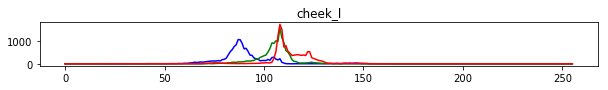

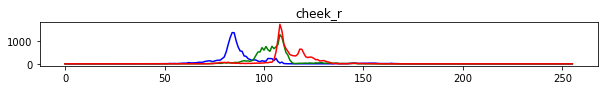

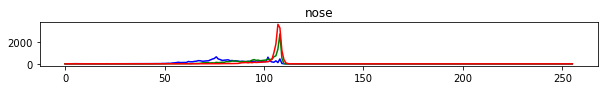

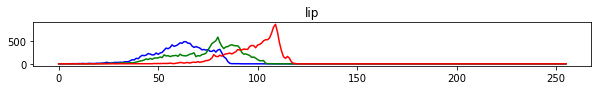

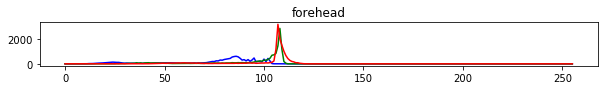

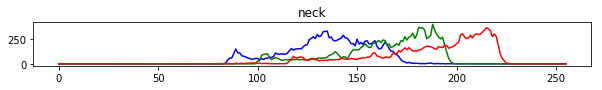

In [17]:
dim = 256
for i, organ_img in enumerate(img_organs):
    img = img_organs[organ_img]
    images.append(img)    
    blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]
    hist_b = cv2.calcHist([img], [0], None, [dim], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [dim], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [dim], [0, 256])

    plt.figure(figsize=(10,8))
    plt.subplot(7, 1, i+1)                             #plot in the first cell
    plt.subplots_adjust(hspace=.5)
    plt.title("blue")
    plt.plot(range(dim), hist_b, color = 'b')
    plt.subplot(7, 1, i+1)                              #plot in the second cell
    plt.title("green")
    plt.plot(range(dim), hist_g, color = 'g')
    plt.subplot(7, 1, i+1)                                 #plot in the third cell
    plt.title(organ_img)
    plt.plot(range(dim), hist_r, color = 'r')
    plt.show()

In [18]:
dim = 256
sample_num = 1
bgr_data = np.zeros( ( sample_num, dim*3  ) )

organ_feat = {}
for organ in img_organs:
    img = img_organs[organ]
    hist_b = cv2.calcHist([img], [0], None, [dim], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [dim], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [dim], [0, 256])
    
    organ_feat[organ] = np.concatenate([hist_b, hist_g, hist_r]).T
    

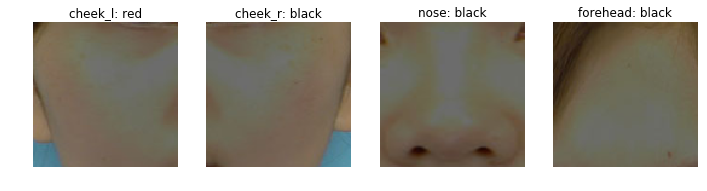

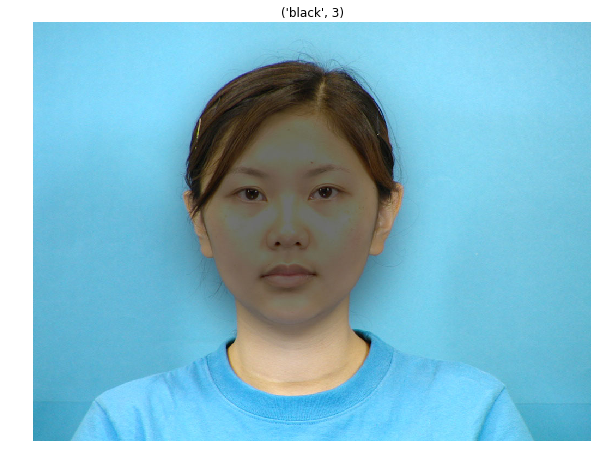

面黑色：
面黑色主肾虚证、水饮证、寒证、痛证及淤血证。黑为阴寒水盛之色。由于肾阳虚衰，水饮不化，气化不行，阴寒内盛，血失温养，经脉拘急，气血不畅，古面色黧黑。
黑色对应肾，面色黑多与肾有关。肾主藏精。肾精充盈，肾气旺盛时，五脏功能方可正常运行。推荐几种养肾食物，如海带、紫菜、海参等都是很好的养肾食物。


In [19]:
from sklearn.neighbors import KNeighborsClassifier

predicts = []
results = []
res_imgs = []
for organ in organ_feat:
    try:
        model = joblib.load('./models/mlp_'+organ+'_model.m')
#         print ('./models/mlp_'+organ+'_model.m')
        # predict data
        predict = model.predict(organ_feat[organ])
        predicts.append(color_labels[predict[0]])
        results.append(organ+': '+color_labels[predict[0]])
#         print (organ)
#         print (color_labels[predict[0]])
        res_imgs.append(img_organs[organ])
        
    except Exception:
        pass
grid_display(res_imgs, results, 5, (15,15), 1, conv_color = True)
color_diagnose = Counter(predicts).most_common(1)
grid_display(img_origs, color_diagnose, 1, (10,10), 1, conv_color = True)
# print (color_diagnose[0][0])
print (face_diagnose[color_diagnose[0][0]])